In [54]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import dill
import loss_functions as lf
from Optimal_Stopping_Object import ModelConstructor, ModelFitting
import constants
import data_visualization as dv
from initializer import InitialThangs
from copy import deepcopy

plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')
#* True Parameters load
with open(constants.MODEL_INPUT_PATH / 'model_input_dict.pkl','rb') as f:
    model_input_dict = dill.load(f)
true_parameters = [np.nanmedian(v) for k,v in model_input_dict.items() if "agent" not in k] 
#* Bootstrap Load
with open(constants.MODEL_INPUT_PATH / 'bootstrap_parameter_distribution.pkl','rb') as f:
    parameter_distribution = dill.load(f)    
with open(constants.MODEL_INPUT_PATH / 'bootstrap_results.pkl','rb') as f:
    results = dill.load(f)    
with open(constants.MODEL_INPUT_PATH / 'participant_ids.pkl','rb') as f:
    participant_ids = dill.load(f)        
#* Comparison Targets load
with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
    participant_median_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
    participant_sd_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
    participant_wins = dill.load(f)  
with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
    participant_incorrects = dill.load(f)  
with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
    participant_indecisions = dill.load(f)  


In [55]:
SAVE_PATH = Path("D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures\paper")
EXPERIMENT = "Exp1"
it = InitialThangs(EXPERIMENT)

BOOTSTRAPPED_MODELS = False
if BOOTSTRAPPED_MODELS:
    p = "bootstrapped"
else:
    p = "warmstart"
    
MODEL_TO_FIT = "optimal"
path = constants.MODELS_PATH / f"{p}_models"
results_file = list(path.glob(f"{EXPERIMENT}_{MODEL_TO_FIT}_{p}_results*"))[-1]
inputs_file = list(path.glob(f"{EXPERIMENT}_{MODEL_TO_FIT}_{p}_inputs*"))[-1]
df_results = pd.read_pickle(path / results_file)
df_inputs = pd.read_pickle(path / inputs_file)

In [56]:
df_inputs.columns

Index(['Model', 'Loss', 'fit_parameters', 'experiment', 'num_blocks',
       'agent_means', 'agent_sds', 'nsteps', 'num_timesteps', 'round_num',
       'expected', 'key', 'reaction_sd', 'movement_sd', 'timing_sd',
       'guess_switch_sd', 'guess_sd', 'use_true_guess_sd',
       'electromechanical_sd', 'guess_sd_from_data', 'reaction_time',
       'movement_time', 'guess_switch_delay', 'electromechanical_delay',
       'guess_delay', 'win_reward', 'incorrect_cost', 'indecision_cost',
       'prob_selecting_correct_target_reaction',
       'prob_selecting_correct_target_guess'],
      dtype='object')

In [57]:
np.max(np.stack(df_inputs["Loss"].to_numpy()).squeeze())

14.898718156325591

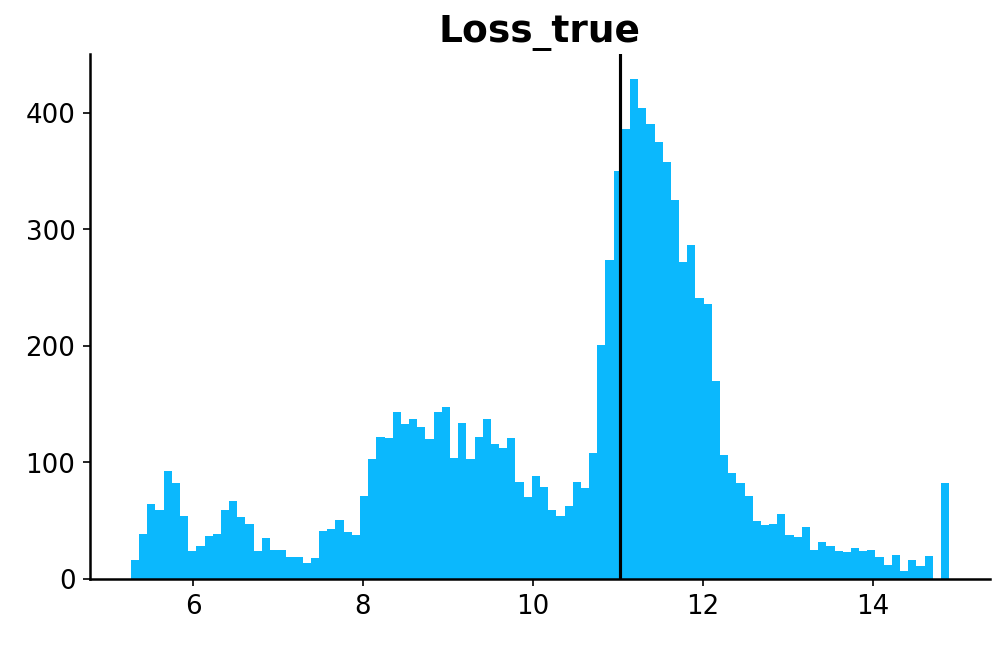

In [58]:
columns = ["Loss","reaction_sd","movement_sd","timing_sd",
           "guess_sd","reaction_time","movement_time","guess_switch_delay",
           "guess_switch_sd",]
for i,col_name in enumerate(columns[0:1]):
    col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
    col = np.where(col>40,np.nan,col)
    for j in range(2): # Looping through true and expected
        if col.ndim == 1:
            hist = col
            median = np.nanmedian(col)
            sd = np.nanstd(col)
            
        elif col.ndim == 2:
            hist = col[:,j]
            median = np.nanmedian(col[:,j])
            sd = np.nanstd(col[:,j])
        elif col.ndim == 3:
            hist = col[:,j,0]
            median = np.nanmedian(col[:,j,0])
        if j == 0:
            end_title = "_true"
        else:
            end_title = "_expected"
        
        fig = dv.Figure()
        ax = fig.add_panel((0.5, 0, 6, 3.5))
        ax.hist(hist,align='mid',bins=100)
        ax.axvline(median)
        ax.set_title(col_name + end_title)
        fig.remove_figure_borders()
        plt.show()
        if col_name == "Loss":
            break
        

In [59]:
with open(constants.MODELS_PATH / "warmstart_models" / f"{EXPERIMENT}_test_{MODEL_TO_FIT}_warmstart_inputs.pkl", "rb") as f:
    base_model_df = dill.load(f)
comparison_targets = np.array(
            [
                np.nanmedian(participant_median_movement_onset_time, axis=0),
                np.nanmedian(participant_sd_movement_onset_time, axis=0),
                np.nanmedian(participant_wins,axis=0)/it.num_trials,
                np.nanmedian(participant_incorrects,axis=0)/it.num_trials,
                np.nanmedian(participant_indecisions,axis=0)/it.num_trials,
            ]   
        )
free_params = {
            "guess_switch_delay": base_model_df['guess_switch_delay'].squeeze()[0].squeeze(),
            "guess_switch_sd": base_model_df['guess_switch_sd'].squeeze()[0].squeeze(),
            }
for i, (index, row) in enumerate(base_model_df.iterrows()):
    print(row.guess_switch_delay)
    print("_______________")
    model  = ModelConstructor(
        experiment=EXPERIMENT,
        num_blocks=row.num_blocks,
        num_timesteps=1800,
        agent_means=row.agent_means,
        agent_sds=row.agent_sds, #!
        reaction_time=row.reaction_time,
        movement_time=row.movement_time,
        reaction_sd=row.reaction_sd, #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=row.movement_sd,
        timing_sd=row.timing_sd,
        guess_switch_delay=row.guess_switch_delay, # Designed like this for broadcasting reasons
        guess_switch_sd=row.guess_switch_sd, # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_sd = row.electromechanical_sd,
        electromechanical_delay=row.electromechanical_delay,
        switch_cost_exists=True,
        expected=False,
        win_reward=row.win_reward,
        incorrect_cost=row.incorrect_cost,
        indecision_cost=row.indecision_cost,
        round_num = 20,
        use_agent_behavior_lookup = False,
    )
    # model1  = deepcopy(model)
    
    # print(model.inputs.guess_switch_sd)
    # print(model.inputs.guess_switch_delay)
    # print(model1.inputs.guess_switch_sd)
    # print(model1.inputs.guess_switch_delay)
    model_metric_keys = ['wtd_leave_time','wtd_leave_time_sd','prob_win','prob_incorrect','prob_indecision']
    # model_fit_object = ModelFitting(model=model)
    # res = model_fit_object.run_model_fit_procedure(
    #     free_params_init=free_params,
    #     targets=comparison_targets,
    #     drop_condition_from_loss=None,  # Drop 1200 50
    #     metric_keys=model_metric_keys,
    #     bnds=None,
    #     xtol=0.0001,
    #     ftol =0.1,
    #     maxfev = 500,
    #     maxiter = 500,
    #     method="Nelder-Mead",

    # )
    # print(model.inputs.guess_switch_sd)
    # print(model.inputs.guess_switch_delay)
    # print(model1.inputs.guess_switch_sd)
    # print(model1.inputs.guess_switch_delay)
    # model_fit_object1 = ModelFitting(model=model1)
    # res1 = model_fit_object1.run_model_fit_procedure(
    #     free_params_init=free_params,
    #     targets=comparison_targets,
    #     drop_condition_from_loss=None,  # Drop 1200 50
    #     metric_keys=model_metric_keys,
    #     bnds=None,
    #     xtol=0.0001,
    #     ftol =0.1,
    #     maxfev = 500,
    #     maxiter = 500,
    #     method="Nelder-Mead",
    # )
    # print(model.inputs.guess_switch_sd)
    # print(model.inputs.guess_switch_delay)
    # print(model1.inputs.guess_switch_sd)
    # print(model1.inputs.guess_switch_delay)
get_metric = model.results.get_metric
model_data = [
    get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal'),
    get_metric(model.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='optimal'),
    get_metric(model.score_metrics.prob_indecision,metric_type='true',decision_type='optimal')*100,
    get_metric(model.score_metrics.prob_win,metric_type='true',decision_type='optimal')*100,
    get_metric(model.score_metrics.prob_incorrect,metric_type='true',decision_type='optimal')*100,
]
results_row = {
    "median_movement_onset_time":model_data[0],
    "sd_movement_onset_time":model_data[1],
    "indecisions":model_data[2],
    "wins":model_data[3],
    "incorrects":model_data[4],
}
# res

[[[60]]

 [[60]]]
_______________


In [67]:
vars(model.inputs)

{'experiment': 'Exp1',
 'num_blocks': 6,
 'agent_means': array([[[1000.21517143],
         [1003.90947609],
         [1098.90717087],
         [1096.61914711],
         [1198.84113998],
         [1197.72468643]],
 
        [[1000.21517143],
         [1003.90947609],
         [1098.90717087],
         [1096.61914711],
         [1198.84113998],
         [1197.72468643]]]),
 'agent_sds': array([[[ 48.50451554],
         [144.43657221],
         [ 47.57923666],
         [146.38181471],
         [ 50.9035165 ],
         [142.95629093]],
 
        [[ 48.50451554],
         [144.43657221],
         [ 47.57923666],
         [146.38181471],
         [ 50.9035165 ],
         [142.95629093]]]),
 'nsteps': 1,
 'num_timesteps': 1800,
 'timesteps': array([[[0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
  

In [60]:
model_metrics = np.zeros_like(comparison_targets)
for i in range(comparison_targets.shape[0]): 
    if 'leave_time' in model_metric_keys[i]:
        model_metric = getattr(model.player_behavior, model_metric_keys[i])
        # Find the metric at optimal decision time
        #! Metric type always being 'true' means that the metric array we're using is ALWAYS the 'true' array. 
        model_metrics[i,:] = model.results.get_metric(model_metric, 
                                                            decision_type="optimal", 
                                                            metric_type="true")  
    elif 'decision_time' in model_metric_keys[i]:
        model_metric = getattr(model.results,model_metric_keys[i])
        model_metrics[i,:] = model_metric
    else:
        model_metric = getattr(model.score_metrics, model_metric_keys[i])
        model_metrics[i,:] = model.results.get_metric(model_metric, 
                                                            decision_type="optimal", 
                                                            metric_type="true")  # Find the metric at optimal decision time
        
loss = lf.ape_loss(model_metrics, comparison_targets,)
loss

9.44990054070167

In [61]:
model_metrics

array([[1.24146519e+03, 1.19551006e+03, 1.34018405e+03, 1.18039200e+03,
        1.77000000e+02, 1.06942506e+03],
       [6.14297122e+01, 1.25391393e+02, 6.07060739e+01, 1.26254204e+02,
        1.39375954e+02, 1.36291090e+02],
       [9.06103885e-01, 7.21177930e-01, 5.43717213e-01, 6.11693456e-01,
        5.00745671e-01, 5.81234334e-01],
       [1.55530990e-09, 1.09115538e-01, 1.86090140e-05, 2.64943727e-01,
        4.99254329e-01, 3.92523170e-01],
       [9.38961139e-02, 1.69706532e-01, 4.56264178e-01, 1.23362816e-01,
        0.00000000e+00, 2.62424963e-02]])

In [62]:
other = {'experiment': 'Exp1',
 'num_blocks': 6,
 'agent_means': np.array([[[1000.21517143],
         [1003.90947609],
         [1098.90717087],
         [1096.61914711],
         [1198.84113998],
         [1197.72468643]],
 
        [[1000.21517143],
         [1003.90947609],
         [1098.90717087],
         [1096.61914711],
         [1198.84113998],
         [1197.72468643]]]),
 'agent_sds': np.array([[[ 48.50451554],
         [144.43657221],
         [ 47.57923666],
         [146.38181471],
         [ 50.9035165 ],
         [142.95629093]],
 
        [[ 48.50451554],
         [144.43657221],
         [ 47.57923666],
         [146.38181471],
         [ 50.9035165 ],
         [142.95629093]]]),
 'nsteps': 1,
 'num_timesteps': 1800,
 'timesteps': np.array([[[0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03]],
 
        [[0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03]]]),
 'round_num': 20,
 'expected': False,
 'key': 0,
 'use_agent_behavior_lookup': False,
 'reaction_sd': np.array([[[37.69512147]],
 
        [[37.69512147]]]),
 'movement_sd': np.array([[[23.22162329]],
 
        [[23.22162329]]]),
 'timing_sd': np.array([[[76.61368328],
         [76.61368328],
         [76.61368328],
         [76.61368328],
         [76.61368328],
         [76.61368328]],
 
        [[76.61368328],
         [76.61368328],
         [76.61368328],
         [76.61368328],
         [76.61368328],
         [76.61368328]]]),
 'guess_switch_sd': np.array([[[117]],
 
        [[117]]]),
 'guess_sd': np.array([[[140.20933088],
         [140.20933088],
         [140.20933088],
         [140.20933088],
         [140.20933088],
         [140.20933088]],
 
        [[140.20933088],
         [140.20933088],
         [140.20933088],
         [140.20933088],
         [140.20933088],
         [140.20933088]]]),
 'use_true_guess_sd': False,
 'electromechanical_sd': np.array([[[10]],
 
        [[10]]]),
 'guess_sd_from_data': False,
 'reaction_time': np.array([[[241.25]],
 
        [[241.25]]]),
 'movement_time': np.array([[[151.]],
 
        [[151.]]]),
 'guess_switch_delay': np.array([[[141]],
 
        [[141]]]),
 'electromechanical_delay': np.array([[[50]],
 
        [[50]]]),
 'guess_delay': np.array([[[191]],
 
        [[191]]]),
 'win_reward': 1.0,
 'incorrect_cost': 0.0,
 'indecision_cost': 0.0,
 'prob_selecting_correct_target_reaction': 1.0,
 'prob_selecting_correct_target_guess': 0.5}

In [63]:
for k,v in other.items():
    print(k)
    try:
        print(np.isclose(v,vars(model.inputs)[k]))
    except:
        v == vars(model.inputs)[k]
    print("-----")

experiment
-----
num_blocks
True
-----
agent_means
[[[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]]
-----
agent_sds
[[[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]]
-----
nsteps
True
-----
num_timesteps
True
-----
timesteps
-----
round_num
True
-----
expected
True
-----
key
True
-----
use_agent_behavior_lookup
True
-----
reaction_sd
[[[ True]]

 [[ True]]]
-----
movement_sd
[[[ True]]

 [[ True]]]
-----
timing_sd
[[[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]]
-----
guess_switch_sd
[[[False]]

 [[False]]]
-----
guess_sd
[[[False]
  [False]
  [False]
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  [False]
  [False]
  [False]]]
-----
use_true_guess_sd
True
-----
electromechanical_sd
[[[ True]]

 [[ True]]]
-----
guess_sd_from_data
True
-----
reaction

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_34532\634922206.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  v == vars(model.inputs)[k]


In [64]:
idmin = np.argmin(np.stack(df_inputs["Loss"].to_numpy()))

np.stack(df_inputs["guess_switch_delay"].to_numpy())[idmin]

array([[[120]],

       [[120]]])

# Find Median and Confidence Intervals

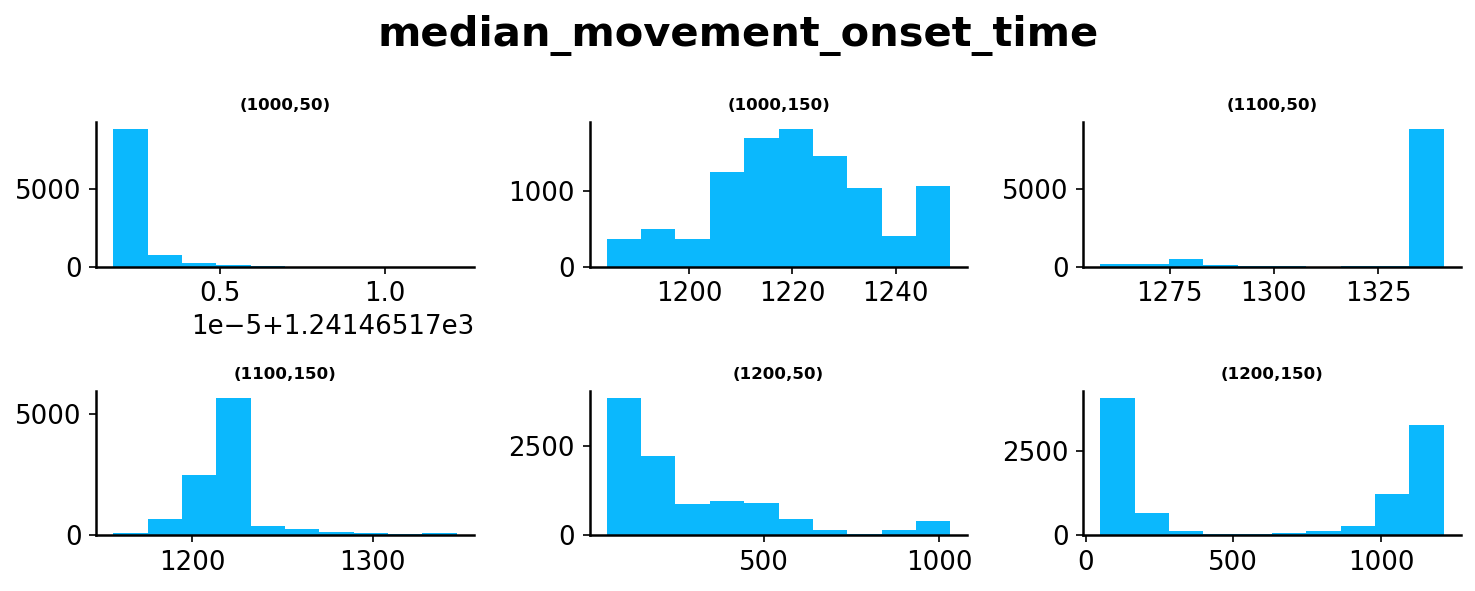

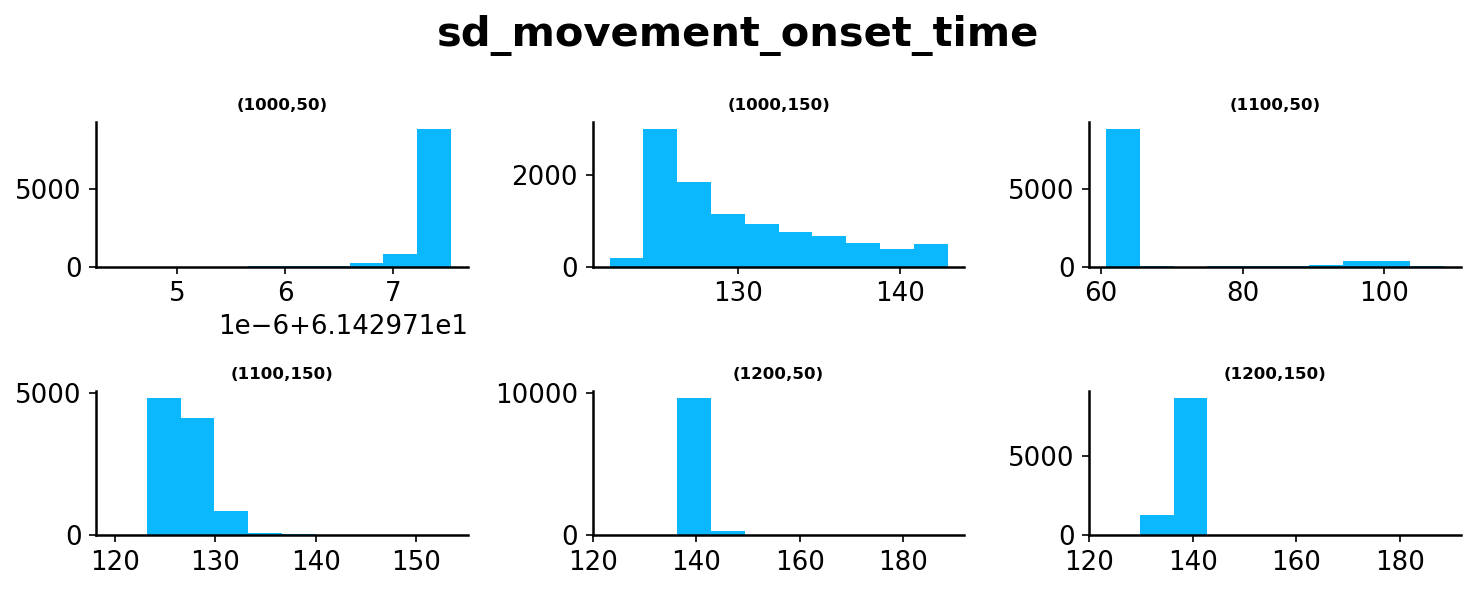

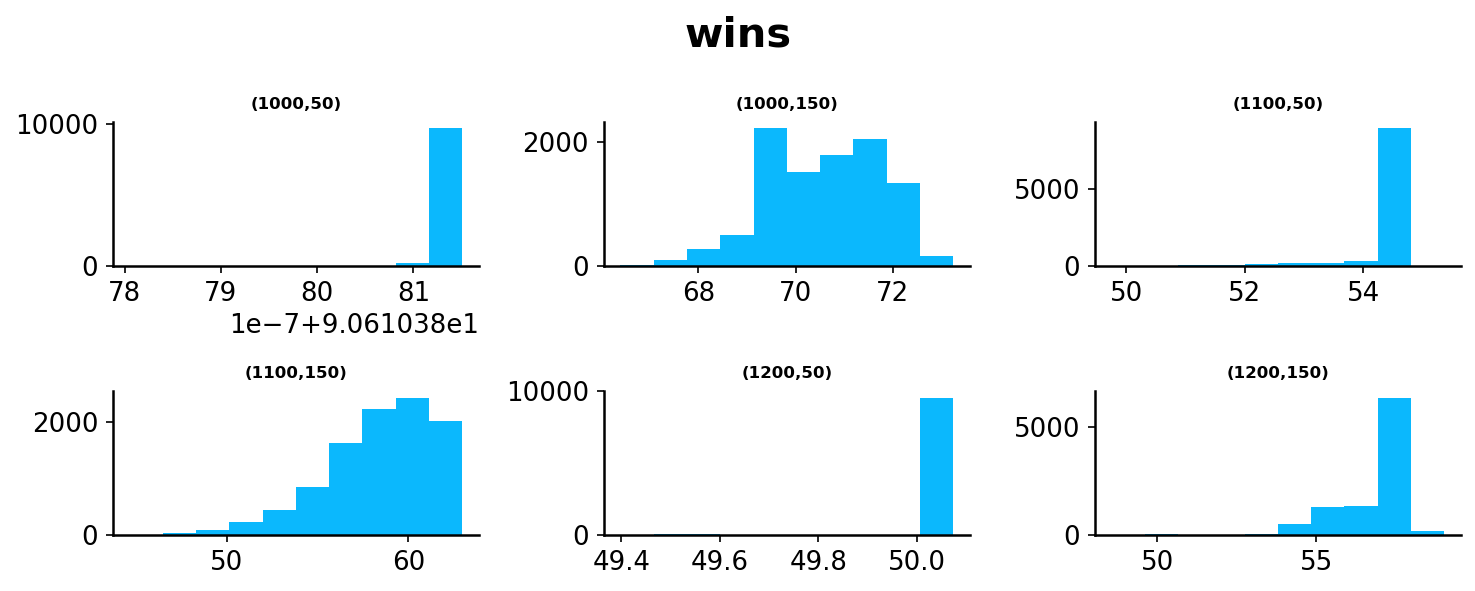

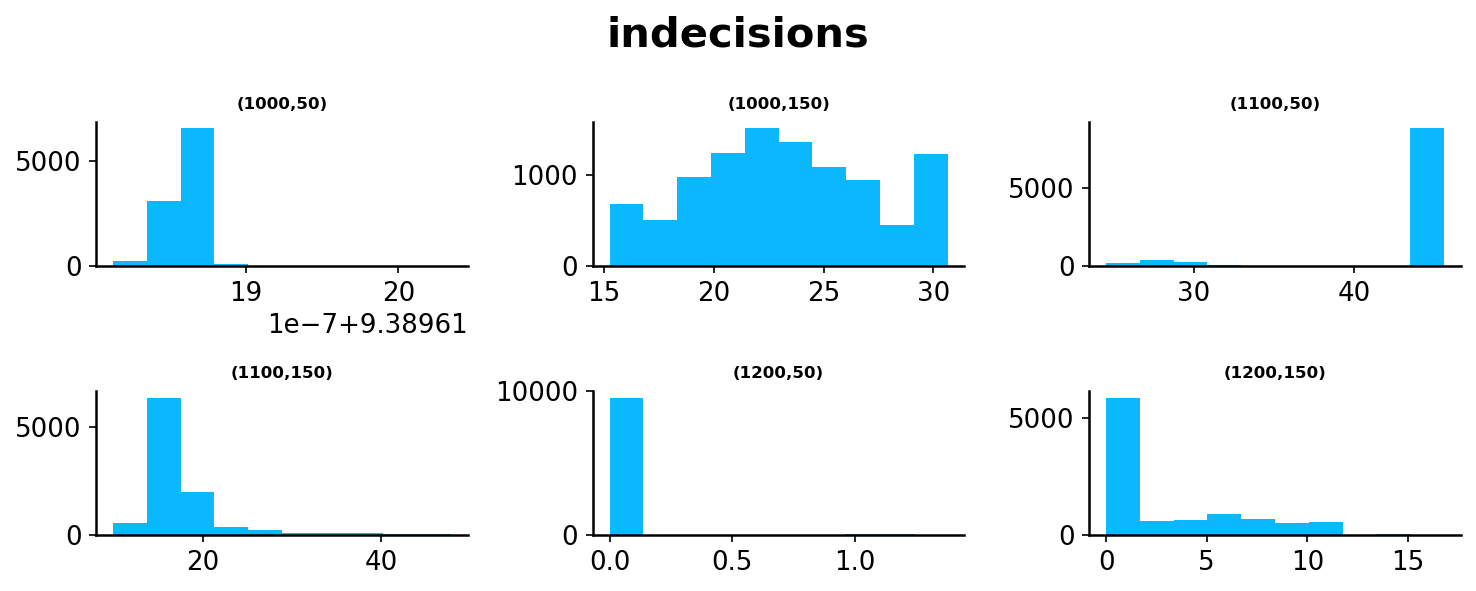

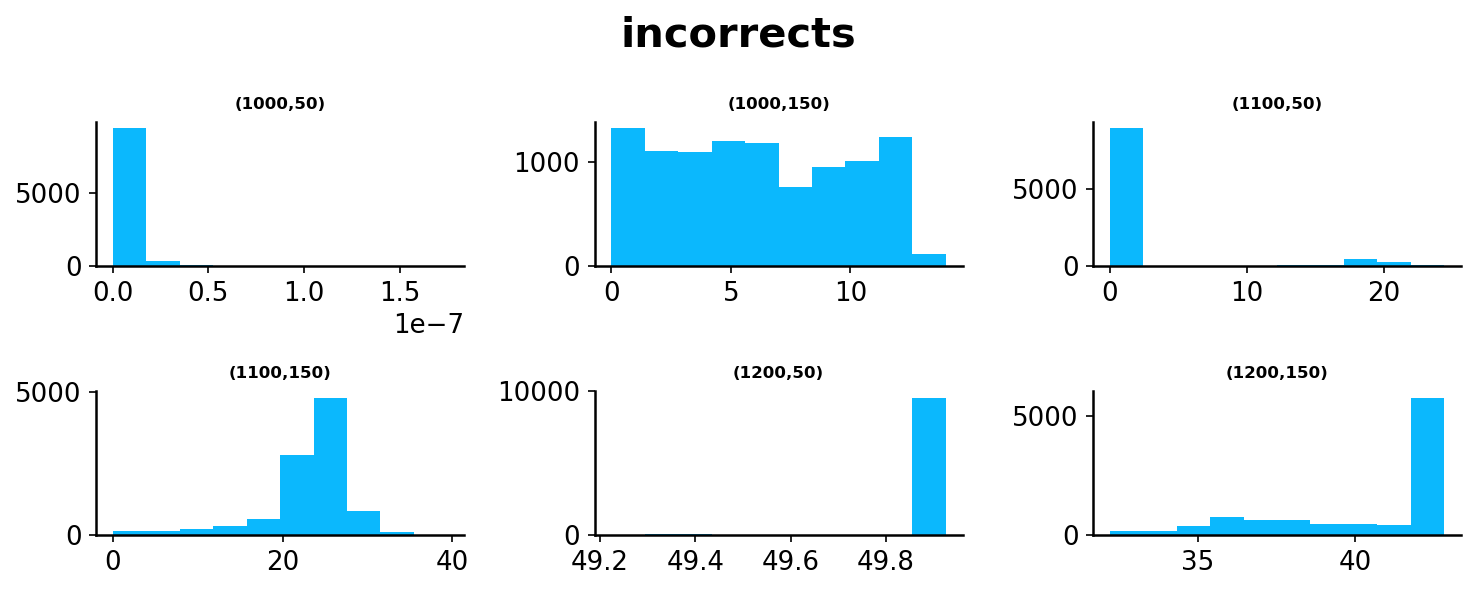

In [65]:
col_names = ["median_movement_onset_time","sd_movement_onset_time",
             "wins","indecisions","incorrects"]
medians = {}
conf_intervals = {}
for col_name in col_names:
    metric = df_results[col_name].to_numpy()
    metric = np.stack(metric)
    fig,axs = plt.subplots(2,3,dpi=150,figsize = (10,4))
    faxs = axs.flatten()
    for j in range(metric.shape[1]):
        ax = faxs[j]
        ax.hist(metric[:,j])
        ax.set_title(it.trial_block_titles[j], fontsize=8)
    fig.suptitle(col_name)
    plt.tight_layout()
    medians.update({col_name:np.median(metric,axis=0)})
    conf_intervals.update({col_name:np.percentile(metric,[2.5,97.5],axis=0)})    

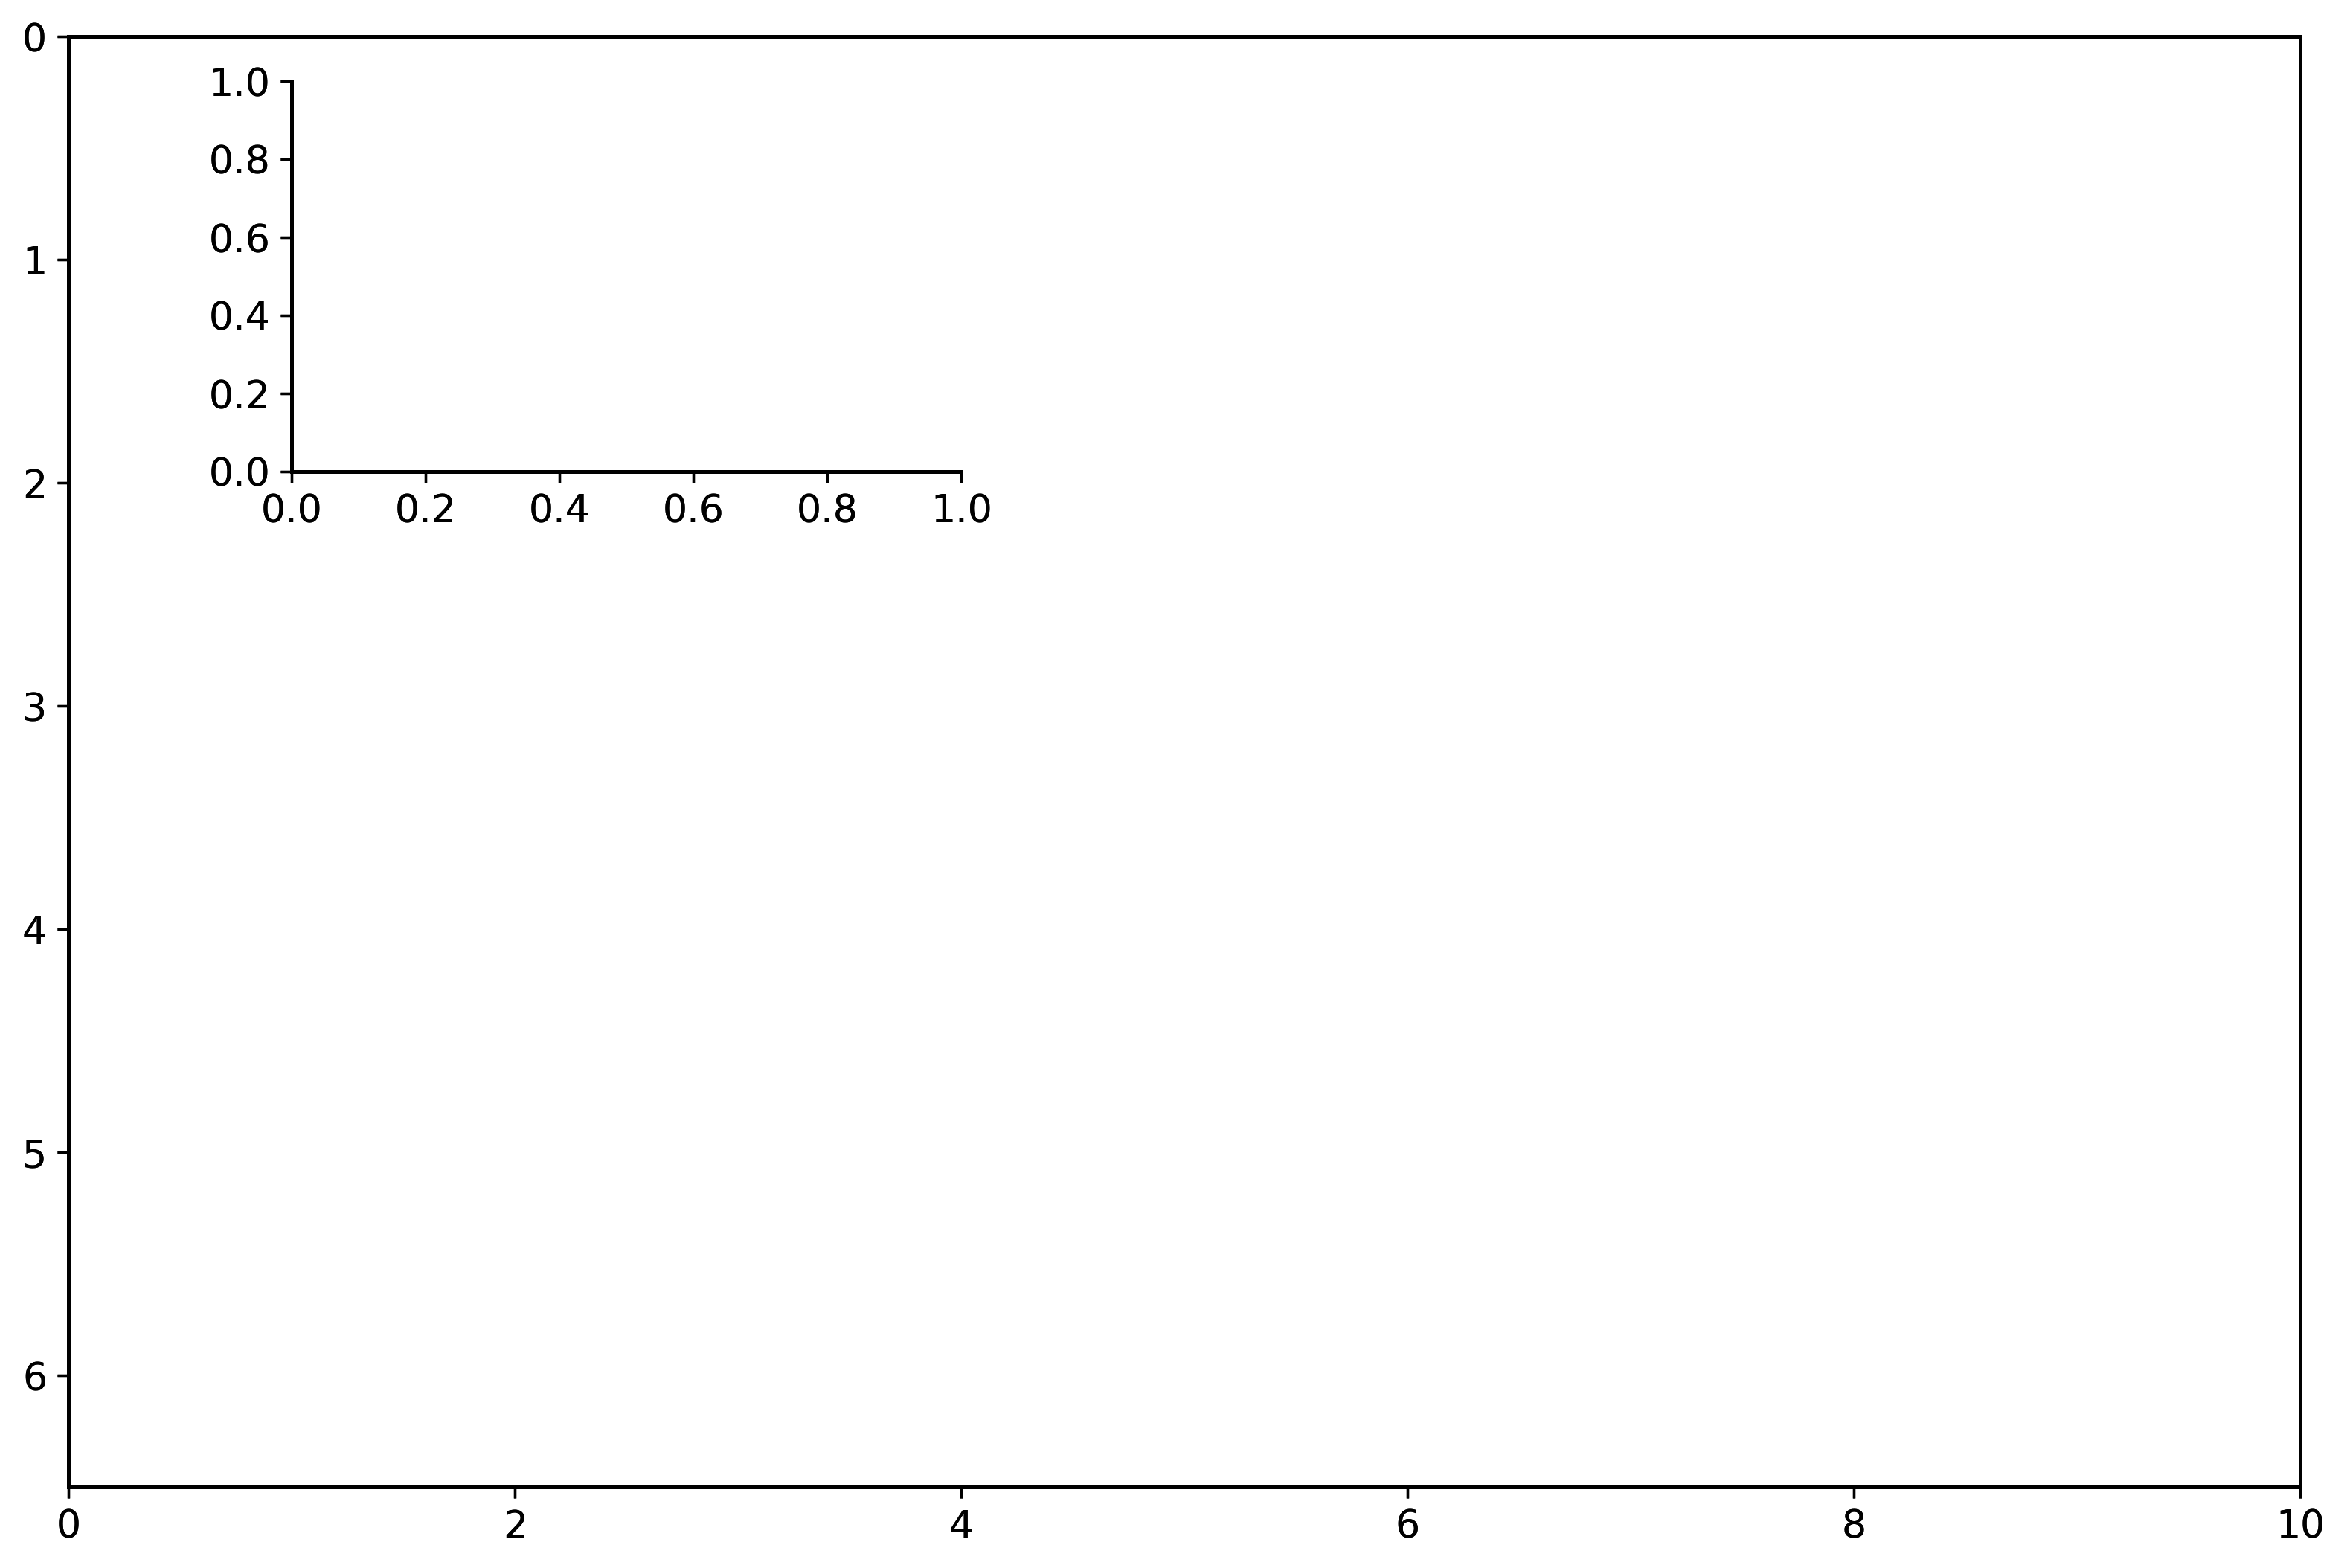

In [66]:
colspan = 3
rowspan=1
fig = dv.Figure(figsize=(10,6.5),dpi=300)
ax1 = fig.add_panel((1,0.2,3,1.75))
ax1 = fig.add_panel((1,0.2,3,1.75))